# Conversión de Datos MEG a CSV - LibriBrain Competition

Este notebook convierte los datos de MEG (archivos .h5) y eventos (archivos .tsv) del dataset LibriBrain en un formato CSV unificado, listo para machine learning.

## Funcionalidades:
- 🔄 Conversión de formato .h5 + .tsv → CSV unificado
- 📊 Análisis de sincronización entre datos MEG y eventos
- 🔧 Downsampling configurable para manejar el tamaño de datos
- 📈 Alineación temporal e interpolación de etiquetas
- 💾 Exportación en formatos normal y comprimido
- 📋 Estadísticas y visualizaciones del resultado

## Estructura del CSV resultante:
- **Columnas MEG**: Datos de sensores (306 canales por defecto)
- **Columna temporal**: Timestamp para cada muestra
- **Columnas de eventos**: Etiquetas interpoladas de los archivos .tsv
- **Metadatos**: Información de sesión y configuración

## 🎯 Cómo usar este notebook

### 📋 **Pasos para convertir tus datos:**

1. **Ejecuta las celdas en orden** (1 → 2 → 3 → 4 → 5 → 6 → 7)

2. **Modifica la configuración** en la celda 3:
   - Cambia `SELECTED_SESSION = "1"` por `"2"` para procesar la sesión 2
   - Ajusta `normalize_data = True/False` para activar/desactivar normalización
   - Cambia `normalization_method` entre 'zscore', 'minmax', o 'robust'
   - Modifica rutas en `DATA_DIR` si tus datos están en otra ubicación

3. **Personaliza la exportación** en la celda 3:
   - Cambia `include_timestamps` para incluir/excluir columna temporal
   - Ajusta `export_compressed` para generar versión comprimida
   - Modifica `csv_precision` para precisión decimal

### 📊 **Estructura del CSV resultante:**

| Columna | Tipo | Descripción |
|---------|------|-------------|
| `timestamp` | float32 | Tiempo en segundos (opcional) |
| `MEG_ch_001` - `MEG_ch_306` | float32 | Señales MEG normalizadas por canal |
| `event_silence` | int8 | 1=Evento silencio activo, 0=inactivo |
| `event_word` | int8 | 1=Evento palabra activo, 0=inactivo |
| `event_phoneme` | int8 | 1=Evento fonema activo, 0=inactivo |
| `word_segment` | object | Palabra/segmento detectado (si aplica) |
| `value_*` | float32 | Valores numéricos interpolados de eventos |

### 🔧 **Configuraciones de normalización recomendadas:**

- **Para modelos lineales/SVM**: `normalization_method = 'zscore'` (μ=0, σ=1)
- **Para redes neurales**: `normalization_method = 'minmax'` (rango [0,1])
- **Para datos con outliers**: `normalization_method = 'robust'` (mediana e IQR)
- **Sin normalización**: `normalize_data = False` (datos originales)

### 💡 **Próximos pasos:**

1. **Carga el CSV** en pandas: `df = pd.read_csv('Sherlock1_ses-1_meg_events_zscore.csv')`
2. **Separa características y etiquetas**: 
   ```python
   meg_cols = [col for col in df.columns if col.startswith('MEG_')]
   event_cols = [col for col in df.columns if col.startswith('event_')]
   X = df[meg_cols].values  # Features MEG (ya normalizados)
   y = df[event_cols].values  # Targets eventos
   ```
3. **Entrena tu modelo** de machine learning directamente
4. **Experimenta** con diferentes métodos de normalización según tu algoritmo

¡Disfruta analizando tus datos de neurociencia normalizados! 🧠✨

In [50]:
# === CONFIGURACIÓN Y LIBRERÍAS ===

import os
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")

# === CONFIGURACIÓN PRINCIPAL ===

# Directorio base de datos
DATA_DIR = "../Data"

# Configuración de procesamiento
CONFIG = {
    'normalize_data': True,  # ¿Aplicar normalización a los datos MEG?
    'normalization_method': 'zscore',  # Método de normalización ('zscore', 'minmax', 'robust')
    'interpolation_method': 'linear',  # Método de interpolación para eventos ('linear', 'nearest', 'zero', 'quadratic')
    'export_compressed': True,  # ¿Exportar también versión comprimida?
    'max_memory_gb': 4.0,  # Límite aproximado de memoria en GB
    'chunk_processing': True,  # ¿Procesar en chunks si es muy grande?
}

# Configuración de exportación
EXPORT_CONFIG = {
    'include_timestamps': True,  # ¿Incluir columna de tiempo?
    'include_metadata': True,   # ¿Incluir metadatos en archivo separado?
    'csv_precision': 6,         # Precisión decimal para CSV
    'compression': 'gzip',      # Tipo de compresión ('gzip', 'bz2', 'xz')
}

print("✅ Configuración cargada")
print(f"📁 Directorio de datos: {DATA_DIR}")
print(f"🔧 Normalización: {CONFIG['normalize_data']} ({CONFIG['normalization_method']})")
print(f"💾 Exportar comprimido: {CONFIG['export_compressed']}")

✅ Configuración cargada
📁 Directorio de datos: ../Data
🔧 Normalización: True (zscore)
💾 Exportar comprimido: True


In [51]:
# === SELECCIÓN DE SESIONES Y VERIFICACIÓN ===

def find_available_sessions(data_dir):
    """Encuentra todas las sesiones disponibles en el directorio de datos"""
    sessions = {}
    
    if not os.path.exists(data_dir):
        print(f"❌ El directorio {data_dir} no existe")
        return sessions
    
    # Buscar en subdirectorios (Sherlock1, Sherlock2, etc.)
    for task_dir in os.listdir(data_dir):
        task_path = os.path.join(data_dir, task_dir)
        if not os.path.isdir(task_path):
            continue
            
        # Buscar archivos .h5 y .tsv
        h5_dir = os.path.join(task_path, "derivatives", "serialised")
        tsv_dir = os.path.join(task_path, "derivatives", "events")
        
        if os.path.exists(h5_dir) and os.path.exists(tsv_dir):
            h5_files = [f for f in os.listdir(h5_dir) if f.endswith('.h5')]
            tsv_files = [f for f in os.listdir(tsv_dir) if f.endswith('.tsv')]
            
            # Extraer números de sesión
            h5_sessions = set()
            tsv_sessions = set()
            
            for f in h5_files:
                if 'ses-' in f:
                    ses_num = f.split('ses-')[1].split('_')[0]
                    h5_sessions.add(ses_num)
            
            for f in tsv_files:
                if 'ses-' in f:
                    ses_num = f.split('ses-')[1].split('_')[0]
                    tsv_sessions.add(ses_num)
            
            # Solo incluir sesiones que tienen ambos archivos
            complete_sessions = h5_sessions.intersection(tsv_sessions)
            
            if complete_sessions:
                sessions[task_dir] = {
                    'sessions': sorted(list(complete_sessions)),
                    'h5_dir': h5_dir,
                    'tsv_dir': tsv_dir
                }
    
    return sessions

def verify_session_files(task, session, sessions_info):
    """Verifica que existan los archivos necesarios para una sesión"""
    if task not in sessions_info:
        return False, f"Task {task} no encontrada"
    
    if session not in sessions_info[task]['sessions']:
        return False, f"Sesión {session} no encontrada para {task}"
    
    # Construir nombres de archivos esperados
    h5_pattern = f"sub-0_ses-{session}_task-{task}_run-1_proc-bads+headpos+sss+notch+bp+ds_meg.h5"
    tsv_pattern = f"sub-0_ses-{session}_task-{task}_run-1_events.tsv"
    
    h5_path = os.path.join(sessions_info[task]['h5_dir'], h5_pattern)
    tsv_path = os.path.join(sessions_info[task]['tsv_dir'], tsv_pattern)
    
    if not os.path.exists(h5_path):
        return False, f"Archivo MEG no encontrado: {h5_path}"
    
    if not os.path.exists(tsv_path):
        return False, f"Archivo de eventos no encontrado: {tsv_path}"
    
    return True, (h5_path, tsv_path)

# Buscar sesiones disponibles
print("🔍 Buscando sesiones disponibles...")
available_sessions = find_available_sessions(DATA_DIR)

if not available_sessions:
    print("❌ No se encontraron sesiones válidas")
else:
    print("✅ Sesiones encontradas:")
    for task, info in available_sessions.items():
        print(f"  📁 {task}: {len(info['sessions'])} sesiones ({', '.join(info['sessions'])})")

# === SELECCIÓN DE SESIÓN A CONVERTIR ===
# Modifica estos valores para seleccionar la sesión a procesar
SELECTED_TASK = "Sherlock1"  # Cambia por: "Sherlock1", "Sherlock2", etc.
SELECTED_SESSION = "1"       # Cambia por el número de sesión deseado

# Verificar selección
if available_sessions:
    is_valid, result = verify_session_files(SELECTED_TASK, SELECTED_SESSION, available_sessions)
    
    if is_valid:
        h5_file_path, tsv_file_path = result
        print(f"\n✅ Sesión seleccionada: {SELECTED_TASK} - Sesión {SELECTED_SESSION}")
        print(f"📄 Archivo MEG: {os.path.basename(h5_file_path)}")
        print(f"📄 Archivo eventos: {os.path.basename(tsv_file_path)}")
        
        # Verificar tamaños de archivo
        h5_size = os.path.getsize(h5_file_path) / (1024**3)  # GB
        tsv_size = os.path.getsize(tsv_file_path) / (1024**2)  # MB
        
        print(f"💾 Tamaño MEG: {h5_size:.2f} GB")
        print(f"💾 Tamaño eventos: {tsv_size:.2f} MB")
        
        # Estimar tamaño del CSV resultante
        estimated_csv_size = h5_size * 1.5  # Estimación aproximada sin downsampling
        print(f"📊 Tamaño estimado CSV: {estimated_csv_size:.2f} GB")
        
    else:
        print(f"❌ Error: {result}")
        h5_file_path = tsv_file_path = None
else:
    h5_file_path = tsv_file_path = None

🔍 Buscando sesiones disponibles...
✅ Sesiones encontradas:
  📁 Sherlock1: 2 sesiones (1, 2)

✅ Sesión seleccionada: Sherlock1 - Sesión 1
📄 Archivo MEG: sub-0_ses-1_task-Sherlock1_run-1_proc-bads+headpos+sss+notch+bp+ds_meg.h5
📄 Archivo eventos: sub-0_ses-1_task-Sherlock1_run-1_events.tsv
💾 Tamaño MEG: 0.32 GB
💾 Tamaño eventos: 1.06 MB
📊 Tamaño estimado CSV: 0.48 GB


In [52]:
# === CARGA Y ANÁLISIS INICIAL DE DATOS ===

def load_meg_data(h5_file_path):
    """Carga datos MEG desde archivo .h5"""
    print("📥 Cargando datos MEG...")
    
    with h5py.File(h5_file_path, 'r') as f:
        # Cargar datos principales (generalmente en 'meg_data' o similar)
        data_keys = list(f.keys())
        
        # Buscar la clave de datos principal
        meg_data = None
        sfreq = None
        times = None
        ch_names = None
        
        # Intentar diferentes nombres comunes
        for key in ['meg_data', 'data', 'raw_data', 'signals']:
            if key in f:
                meg_data = f[key][:]
                print(f"✅ Datos MEG cargados: {meg_data.shape}")
                break
        
        # Intentar cargar metadatos
        if 'sfreq' in f:
            sfreq = f['sfreq'][()]
        elif 'sampling_frequency' in f:
            sfreq = f['sampling_frequency'][()]
        elif 'fs' in f:
            sfreq = f['fs'][()]
        else:
            # Si no encontramos sfreq, calcularlo desde times si está disponible
            if 'times' in f:
                times_data = f['times'][:]
                if len(times_data) > 1:
                    sfreq = 1.0 / (times_data[1] - times_data[0])
        
        if 'times' in f:
            times = f['times'][:]
        elif 'time' in f:
            times = f['time'][:]
        
        # Si aún no tenemos sfreq y tenemos times, calcularlo
        if sfreq is None and times is not None and len(times) > 1:
            sfreq = 1.0 / (times[1] - times[0])
        elif sfreq is None:
            # Valor por defecto basado en el dataset LibriBrain
            sfreq = 250.0  # Hz típico para MEG
            
        if 'ch_names' in f:
            ch_names = [name.decode() if isinstance(name, bytes) else name for name in f['ch_names'][:]]
        elif 'channel_names' in f:
            ch_names = [name.decode() if isinstance(name, bytes) else name for name in f['channel_names'][:]]
    
    # Si no encontramos datos, intentar con la primera clave disponible
    if meg_data is None and data_keys:
        with h5py.File(h5_file_path, 'r') as f:
            first_key = data_keys[0]
            if isinstance(f[first_key], h5py.Dataset):
                meg_data = f[first_key][:]
                print(f"⚠️ Usando datos de '{first_key}': {meg_data.shape}")
    
    return {
        'data': meg_data,
        'sfreq': sfreq,
        'times': times,
        'ch_names': ch_names,
        'n_channels': meg_data.shape[0] if meg_data is not None else None,
        'n_times': meg_data.shape[1] if meg_data is not None else None
    }

def load_events_data(tsv_file_path):
    """Carga datos de eventos desde archivo .tsv"""
    print("📥 Cargando datos de eventos...")
    
    events_df = pd.read_csv(tsv_file_path, sep='\t')
    print(f"✅ Eventos cargados: {events_df.shape}")
    
    # Detectar columna de tiempo (puede ser 'onset', 'timemeg', etc.)
    time_column = None
    possible_time_cols = ['onset', 'timemeg', 'time', 'timestamp']
    for col in possible_time_cols:
        if col in events_df.columns:
            time_column = col
            break
    
    if time_column is None:
        print("⚠️ No se encontró columna de tiempo reconocida")
        return events_df
    
    # Tipos de eventos - buscar diferentes nombres de columnas
    event_type_column = None
    possible_event_cols = ['trial_type', 'kind', 'event_type', 'type']
    for col in possible_event_cols:
        if col in events_df.columns:
            event_type_column = col
            break
    
    if event_type_column:
        event_counts = events_df[event_type_column].value_counts()
        print(f"🏷️ Tipos de eventos: {dict(event_counts)}")
    
    return events_df

# Cargar datos si tenemos archivos válidos
if h5_file_path and tsv_file_path:
    print("=" * 50)
    print("📂 CARGANDO DATOS")
    print("=" * 50)
    
    # Cargar datos MEG
    meg_info = load_meg_data(h5_file_path)
    
    # Cargar eventos
    events_df = load_events_data(tsv_file_path)
    
    print("\n" + "=" * 50)
    print("📊 RESUMEN FINAL")
    print("=" * 50)
    
    if meg_info['data'] is not None:
        duration_meg = meg_info['n_times'] / meg_info['sfreq']
        print(f"🧠 MEG: {meg_info['data'].shape} | {meg_info['sfreq']:.0f} Hz | {duration_meg:.0f}s")
        
        # Verificar sincronización temporal
        if meg_info['sfreq'] and not events_df.empty:
            time_column = None
            for col in ['onset', 'timemeg', 'time', 'timestamp']:
                if col in events_df.columns:
                    time_column = col
                    break
            
            if time_column:
                events_duration = events_df[time_column].max() - events_df[time_column].min()
                sync_status = "✅ Sincronizado" if abs(duration_meg - events_duration) < 10 else "⚠️ Desincronizado"
                print(f"📋 Eventos: {len(events_df)} eventos | {events_duration:.0f}s | {sync_status}")
    
    print("✅ Datos listos para procesamiento")
        
else:
    print("❌ No hay archivos válidos seleccionados")

📂 CARGANDO DATOS
📥 Cargando datos MEG...
✅ Datos MEG cargados: (306, 278000)
📥 Cargando datos de eventos...
✅ Eventos cargados: (12806, 12)
🏷️ Tipos de eventos: {'phoneme': np.int64(9592), 'word': np.int64(2836), 'silence': np.int64(378)}

📊 RESUMEN FINAL
🧠 MEG: (306, 278000) | 250 Hz | 1112s
📋 Eventos: 12806 eventos | 1070s | ⚠️ Desincronizado
✅ Datos listos para procesamiento


In [69]:
# === PROCESAMIENTO Y CONVERSIÓN ===

def normalize_meg_data(meg_data, method='zscore'):
    """Aplica normalización a los datos MEG"""
    print(f"🔄 Normalizando datos MEG ({method})...")
    normalized_data = meg_data.copy()
    if method == 'zscore':
        for i in range(meg_data.shape[0]):
            channel_data = meg_data[i, :]
            mean_val = np.mean(channel_data)
            std_val = np.std(channel_data)
            normalized_data[i, :] = (channel_data - mean_val) / std_val if std_val > 0 else channel_data - mean_val
    elif method == 'minmax':
        for i in range(meg_data.shape[0]):
            channel_data = meg_data[i, :]
            min_val = np.min(channel_data)
            max_val = np.max(channel_data)
            normalized_data[i, :] = (channel_data - min_val) / (max_val - min_val) if max_val > min_val else channel_data - min_val
    elif method == 'robust':
        for i in range(meg_data.shape[0]):
            channel_data = meg_data[i, :]
            median_val = np.median(channel_data)
            iqr = np.percentile(channel_data, 75) - np.percentile(channel_data, 25)
            normalized_data[i, :] = (channel_data - median_val) / iqr if iqr > 0 else channel_data - median_val
    print("✅ Normalización terminada.")
    return normalized_data

def create_time_vector(n_times, sfreq):
    if sfreq is None or sfreq <= 0:
        raise ValueError(f"Frecuencia de muestreo inválida: {sfreq}")
    return np.arange(n_times) / sfreq

def interpolate_kind_segment(events_df, meg_times):
    print(f"🔄 Interpolando 'kind' y 'segment'...")
    time_column = next((col for col in ['onset', 'timemeg', 'time', 'timestamp'] if col in events_df.columns), None)
    if time_column is None:
        print("❌ Sin columna de tiempo en eventos.")
        return pd.DataFrame({'kind': ['silence']*len(meg_times), 'segment': ['']*len(meg_times)})
    
    n_timepoints = len(meg_times)
    interpolated = pd.DataFrame({'kind': ['silence'] * n_timepoints, 'segment': [''] * n_timepoints})
    
    for _, event in events_df.iterrows():
        onset = event[time_column]
        duration = event.get('duration', 0.1)
        start_idx = np.searchsorted(meg_times, onset, side='left')
        end_idx = np.searchsorted(meg_times, onset + duration, side='right')
        
        if start_idx < len(meg_times) and end_idx > start_idx:
            if 'kind' in events_df.columns and pd.notna(event['kind']):
                interpolated.loc[start_idx:end_idx-1, 'kind'] = str(event['kind'])
            
            if 'segment' in events_df.columns and pd.notna(event['segment']):
                segment_str = str(event['segment']).strip()
                if segment_str != '' and segment_str.lower() != 'nan':
                    interpolated.loc[start_idx:end_idx-1, 'segment'] = segment_str
    
    print(f"✅ Interpolación completada.")
    return interpolated

def create_unified_dataframe_only_kind_segment(meg_data, meg_times, interpolated, ch_names=None):
    print("🔄 Unificando datos MEG + kind/segment...")
    meg_columns = [f"MEG_{name}" for name in ch_names] if ch_names and len(ch_names) == meg_data.shape[0] else [f"MEG_ch_{i:03d}" for i in range(meg_data.shape[0])]
    meg_df = pd.DataFrame(meg_data.T, columns=meg_columns)
    meg_df.insert(0, 'timestamp', meg_times)
    meg_df['kind'] = interpolated['kind'].values
    meg_df['segment'] = interpolated['segment'].values
    print(f"✅ DataFrame final: {meg_df.shape}")
    return meg_df

# Procesamiento principal
if meg_info['data'] is not None and not events_df.empty:
    print("=" * 40)
    print("🔄 PROCESANDO DATOS")
    print("=" * 40)
    if CONFIG['normalize_data']:
        processed_meg = normalize_meg_data(meg_info['data'], CONFIG['normalization_method'])
    else:
        processed_meg = meg_info['data']
        print("ℹ️ Sin normalización aplicada")
    processed_sfreq = meg_info['sfreq']
    meg_times = create_time_vector(processed_meg.shape[1], processed_sfreq)
    print(f"⏱️ {len(meg_times)} muestras, {processed_sfreq:.0f} Hz")
    interpolated = interpolate_kind_segment(events_df, meg_times)
    unified_df = create_unified_dataframe_only_kind_segment(processed_meg, meg_times, interpolated, meg_info['ch_names'])
    print(f"✅ Listo para exportar. Shape: {unified_df.shape}")
else:
    print("❌ No se pueden procesar los datos - faltan datos MEG o eventos")
    unified_df = None

🔄 PROCESANDO DATOS
🔄 Normalizando datos MEG (zscore)...
✅ Normalización terminada.
⏱️ 278000 muestras, 250 Hz
🔄 Interpolando 'kind' y 'segment'...
✅ Normalización terminada.
⏱️ 278000 muestras, 250 Hz
🔄 Interpolando 'kind' y 'segment'...
✅ Interpolación completada.
🔄 Unificando datos MEG + kind/segment...
✅ DataFrame final: (278000, 309)
✅ Listo para exportar. Shape: (278000, 309)
✅ Interpolación completada.
🔄 Unificando datos MEG + kind/segment...
✅ DataFrame final: (278000, 309)
✅ Listo para exportar. Shape: (278000, 309)


In [72]:
display(unified_df)

,timestamp,MEG_ch_000,MEG_ch_001,MEG_ch_002,MEG_ch_003,MEG_ch_004,MEG_ch_005,MEG_ch_006,MEG_ch_007,MEG_ch_008,...,MEG_ch_298,MEG_ch_299,MEG_ch_300,MEG_ch_301,MEG_ch_302,MEG_ch_303,MEG_ch_304,MEG_ch_305,kind,segment
0,0.000000,-0.021646,-0.053409,0.051362,-0.026537,-0.030718,-0.040673,-0.031805,-0.053163,-0.011079,...,-0.061713,-0.061064,0.061544,0.060037,-0.061581,0.059759,0.061658,-0.059951,silence,
1,0.004000,-0.478757,0.238369,0.206286,-0.452384,-0.437332,0.160179,-0.338468,-0.044109,0.567378,...,-0.042615,-0.057367,-0.071183,0.205563,0.021133,0.063287,-0.017678,0.064828,silence,
2,0.008000,0.174907,0.087802,0.311190,-0.264913,0.958624,-0.307845,-0.237723,0.612706,0.584792,...,0.009227,-0.206843,-0.146668,0.283168,-0.036643,0.091790,-0.022595,0.104145,silence,
3,0.012000,-0.239003,-0.106033,0.420576,-0.540730,1.030182,-0.732590,-0.697730,0.597613,0.461606,...,0.056140,-0.264555,-0.142368,0.430222,-0.027300,0.123141,-0.035822,0.295644,silence,
4,0.016000,-0.091149,0.442587,0.113984,-0.393649,0.262564,0.252743,-0.228120,0.728292,0.615862,...,0.037473,-0.213780,-0.142358,0.360843,-0.053651,0.052591,0.003307,0.353677,silence,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277995,1111.980068,10.583074,20.810787,-22.219280,12.863697,12.463695,17.334427,14.591248,20.689631,0.456418,...,25.852848,25.766745,-25.696270,-25.317083,25.846436,-25.473394,-25.683216,24.843433,silence,
277996,1111.984068,8.929490,19.723433,-20.777004,11.694379,9.798613,16.682808,13.340053,18.589727,0.405862,...,23.933748,23.871040,-23.770803,-23.621628,23.938734,-23.694717,-23.738176,23.089283,silence,
277997,1111.988068,10.920054,21.243599,-22.608257,13.296044,12.389984,17.856327,14.951690,20.954407,-0.194399,...,26.178047,26.181282,-25.920919,-25.743574,26.176090,-25.660837,-25.984201,25.104307,silence,
277998,1111.992068,9.066112,18.168119,-19.294607,11.118713,11.080996,15.266564,12.462557,17.921576,-0.033937,...,22.616964,22.496979,-22.366734,-22.277344,22.574329,-22.020256,-22.470587,21.520103,silence,


In [71]:
# === EXPORTACIÓN A CSV ===

def export_to_csv(df, base_filename, config):
    """Exporta DataFrame a CSV sin compresión"""
    # Usar valores por defecto si las claves no existen
    csv_precision = config.get('csv_precision', 6)
    
    # Exportación CSV normal
    csv_filename = f"{base_filename}.csv"
    print(f"💾 Exportando CSV: {csv_filename}")
    
    df.to_csv(
        csv_filename, 
        index=False, 
        float_format=f'%.{csv_precision}f'
    )
    
    csv_size = os.path.getsize(csv_filename) / (1024**3)  # GB
    print(f"  ✅ Guardado: {csv_size:.2f} GB")
    
    return {
        'filename': csv_filename,
        'size_gb': csv_size
    }

def create_metadata_file(base_filename, meg_info, events_df, config, export_config):
    """Crea archivo de metadatos con información del procesamiento"""
    metadata = {
        'processing_info': {
            'source_task': SELECTED_TASK,
            'source_session': SELECTED_SESSION,
            'normalize_data': config.get('normalize_data', True),
            'normalization_method': config.get('normalization_method', 'zscore'),
            'interpolation_method': config.get('interpolation_method', 'linear'),
            'csv_precision': export_config.get('csv_precision', 6)
        },
        'meg_data': {
            'original_shape': list(meg_info['data'].shape) if meg_info['data'] is not None else None,
            'original_sfreq': meg_info['sfreq'],
            'processed_sfreq': meg_info['sfreq'],  # Sin downsampling, la frecuencia se mantiene
            'n_channels': meg_info['n_channels'],
            'channel_names': meg_info['ch_names'][:10] if meg_info['ch_names'] else None  # Primeros 10
        },
        'events_data': {
            'n_events': len(events_df),
            'event_types': events_df['kind'].unique().tolist() if 'kind' in events_df.columns else 
                          events_df['trial_type'].unique().tolist() if 'trial_type' in events_df.columns else [],
            'time_range': [float(events_df['timemeg'].min()), float(events_df['timemeg'].max())] if 'timemeg' in events_df.columns else
                         [float(events_df['onset'].min()), float(events_df['onset'].max())] if 'onset' in events_df.columns else []
        }
    }
    
    metadata_filename = f"{base_filename}_metadata.json"
    
    import json
    with open(metadata_filename, 'w') as f:
        json.dump(metadata, f, indent=2, default=str)
    
    print(f"📋 Metadatos guardados: {metadata_filename}")
    return metadata_filename

# === EXPORTACIÓN PRINCIPAL ===
if unified_df is not None:
    print("=" * 60)
    print("💾 EXPORTANDO RESULTADOS")
    print("=" * 60)
    
    # Crear nombre base para archivos
    normalization_suffix = CONFIG['normalization_method'] if CONFIG['normalize_data'] else 'raw'
    base_filename = f"{SELECTED_TASK}_ses-{SELECTED_SESSION}_meg_events_{normalization_suffix}"
    
    # Exportar CSV
    export_result = export_to_csv(unified_df, base_filename, EXPORT_CONFIG)
    
    # Crear metadatos si está habilitado
    if EXPORT_CONFIG.get('include_metadata', True):
        metadata_file = create_metadata_file(
            base_filename, meg_info, events_df, CONFIG, EXPORT_CONFIG
        )
    
    print("\n" + "=" * 60)
    print("✅ ARCHIVO CSV EXPORTADO")
    print("=" * 60)
    print(f"📁 Archivos generados:")
    print(f"  📄 CSV: {export_result['filename']} ({export_result['size_gb']:.2f} GB)")
    
    if EXPORT_CONFIG.get('include_metadata', True):
        print(f"  📋 Metadatos: {metadata_file}")
    
    print(f"\n🎯 Dataset listo para machine learning!")
    print(f"  📊 {unified_df.shape[0]} muestras × {unified_df.shape[1]} features")
    print(f"  🧠 {len([c for c in unified_df.columns if c.startswith('MEG_')])} canales MEG")
    print(f"  📋 {len([c for c in unified_df.columns if c.startswith('event_')])} tipos de eventos")
    
else:
    print("❌ No se puede exportar - fallo en el procesamiento")

💾 EXPORTANDO RESULTADOS
💾 Exportando CSV: Sherlock1_ses-1_meg_events_zscore.csv
  ✅ Guardado: 0.76 GB
📋 Metadatos guardados: Sherlock1_ses-1_meg_events_zscore_metadata.json

✅ ARCHIVO CSV EXPORTADO
📁 Archivos generados:
  📄 CSV: Sherlock1_ses-1_meg_events_zscore.csv (0.76 GB)
  📋 Metadatos: Sherlock1_ses-1_meg_events_zscore_metadata.json

🎯 Dataset listo para machine learning!
  📊 278000 muestras × 309 features
  🧠 306 canales MEG
  📋 0 tipos de eventos
  ✅ Guardado: 0.76 GB
📋 Metadatos guardados: Sherlock1_ses-1_meg_events_zscore_metadata.json

✅ ARCHIVO CSV EXPORTADO
📁 Archivos generados:
  📄 CSV: Sherlock1_ses-1_meg_events_zscore.csv (0.76 GB)
  📋 Metadatos: Sherlock1_ses-1_meg_events_zscore_metadata.json

🎯 Dataset listo para machine learning!
  📊 278000 muestras × 309 features
  🧠 306 canales MEG
  📋 0 tipos de eventos


📊 Categorías en 'kind': {'phoneme': 194936, 'silence': 83059, 'word': 5}
📏 Datos totales a visualizar: 278000 muestras
🔍 Períodos de habla encontrados: 194941
🔍 Períodos de silencio encontrados: 83059


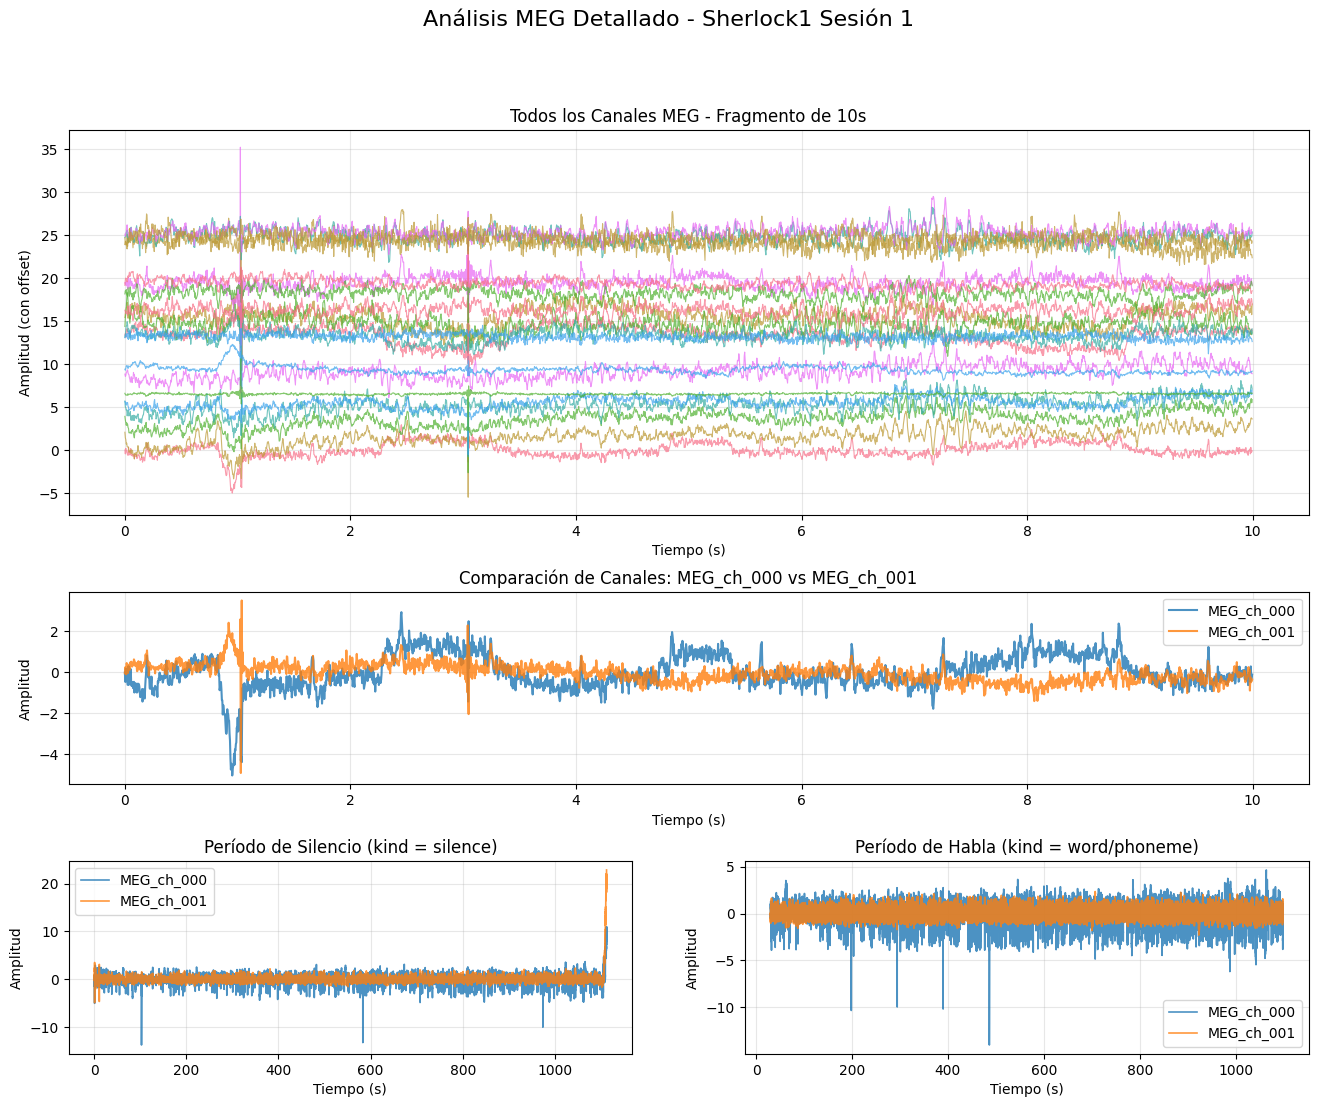


📊 Verificación de contadores:
  Total de muestras: 278,000
  Muestras de habla (word + phoneme): 194,941
  Muestras de silencio: 83,059
  Suma habla + silencio: 278,000
  Distribución real en 'kind': {'phoneme': np.int64(194936), 'silence': np.int64(83059), 'word': np.int64(5)}


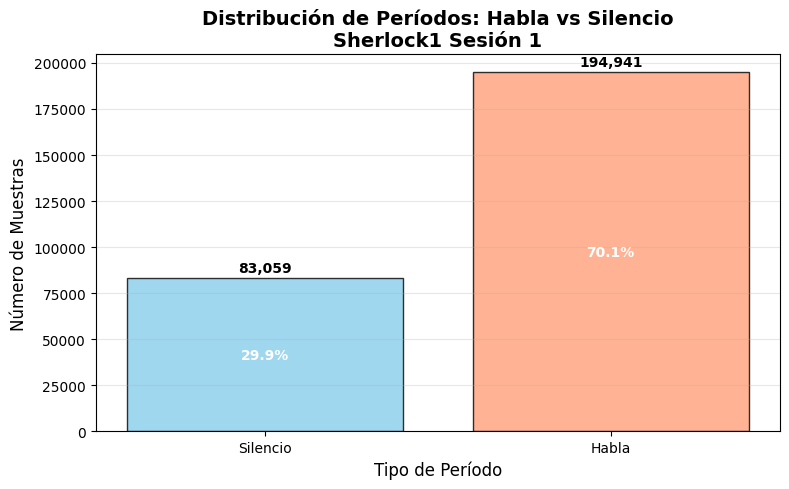

In [79]:
# === ANÁLISIS Y VISUALIZACIONES AVANZADAS ===

# Configuración de visualización
VISUALIZATION_CONFIG = {
    'time_window_seconds': 10,  # Ventana de tiempo a visualizar
    'selected_channels': ['MEG_0113', 'MEG_0023'],  # Canales a comparar (ajustar según tus datos)
    'figsize': (16, 12)
}

def create_meg_visualization(df):
    """
    Crea visualizaciones especializadas de datos MEG
    """
    if df is None or df.empty:
        print("❌ No hay datos para visualizar")
        return
    
    # Obtener configuración
    time_window = VISUALIZATION_CONFIG['time_window_seconds']
    selected_channels = VISUALIZATION_CONFIG['selected_channels']
    figsize = VISUALIZATION_CONFIG['figsize']
    
    # Preparar datos
    meg_cols = [col for col in df.columns if col.startswith('MEG_')]
    time_col = 'timestamp' if 'timestamp' in df.columns else 'time'
    
    if not meg_cols or time_col not in df.columns:
        print("❌ No se encontraron datos MEG o columna de tiempo")
        return
    
    # Ajustar canales seleccionados si no existen
    available_channels = [ch for ch in selected_channels if ch in meg_cols]
    if not available_channels:
        available_channels = meg_cols[:2]  # Usar los primeros 2 canales disponibles
    
    # Usar todo el DataFrame en lugar de solo un fragmento
    df_fragment = df.copy()
    
    if df_fragment.empty:
        print("❌ No hay datos para visualizar")
        return
    
    # Verificar categorías de 'kind' disponibles en todo el DataFrame
    print(f"📊 Categorías en 'kind': {df_fragment['kind'].value_counts().to_dict()}")
    print(f"📏 Datos totales a visualizar: {len(df_fragment)} muestras")
    
    # Para las gráficas 1 y 2, usar solo un fragmento de tiempo para mejor visualización
    time_mask = df[time_col] <= df[time_col].min() + time_window
    df_time_fragment = df[time_mask].copy()
    
    # Crear figura con 3 subplots
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1], hspace=0.3, wspace=0.2)
    
    # === GRÁFICA 1: TODOS LOS CANALES (ocupa todo el ancho) ===
    ax1 = fig.add_subplot(gs[0, :])
    channels_to_plot = meg_cols[::max(1, len(meg_cols)//20)]  # Subsamplear canales
    for i, channel in enumerate(channels_to_plot):
        offset = i * 2 * df_time_fragment[channel].std()
        ax1.plot(df_time_fragment[time_col], 
                df_time_fragment[channel] + offset, 
                linewidth=0.8, alpha=0.7, label=channel if i < 5 else "")
    ax1.set_xlabel('Tiempo (s)')
    ax1.set_ylabel('Amplitud (con offset)')
    ax1.set_title(f'Todos los Canales MEG - Fragmento de {time_window}s')
    ax1.grid(True, alpha=0.3)
    if len(channels_to_plot) <= 5:
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # === GRÁFICA 2: COMPARACIÓN DE 2 CANALES ===
    ax2 = fig.add_subplot(gs[1, :])
    for i, channel in enumerate(available_channels[:2]):
        ax2.plot(df_time_fragment[time_col], 
                df_time_fragment[channel], 
                linewidth=1.5, alpha=0.8, 
                label=f'{channel}',
                color=plt.cm.tab10(i))
    ax2.set_xlabel('Tiempo (s)')
    ax2.set_ylabel('Amplitud')
    ax2.set_title(f'Comparación de Canales: {" vs ".join(available_channels[:2])}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # === GRÁFICA 3: COMPARACIÓN DE 2 CANALES EN SILENCIO Y HABLA SEGÚN 'kind' ===
    ax3_left = fig.add_subplot(gs[2, 0])
    ax3_right = fig.add_subplot(gs[2, 1])
    
    # Filtrar períodos de habla y silencio usando la columna 'kind'
    # Usar comparaciones más flexibles para detectar las categorías
    habla_mask = (df_fragment['kind'] == 'word') | (df_fragment['kind'] == 'phoneme')
    silencio_mask = df_fragment['kind'] == 'silence'
    
    print(f"🔍 Períodos de habla encontrados: {habla_mask.sum()}")
    print(f"🔍 Períodos de silencio encontrados: {silencio_mask.sum()}")
    
    # Gráfica izquierda: Período de silencio
    if silencio_mask.sum() > 0:
        for i, channel in enumerate(available_channels[:2]):
            ax3_left.plot(df_fragment.loc[silencio_mask, time_col],
                          df_fragment.loc[silencio_mask, channel],
                          linewidth=1.2, alpha=0.8,
                          label=f'{channel}',
                          color=plt.cm.tab10(i))
        ax3_left.set_title('Período de Silencio (kind = silence)')
        ax3_left.set_xlabel('Tiempo (s)')
        ax3_left.set_ylabel('Amplitud')
        ax3_left.legend()
        ax3_left.grid(True, alpha=0.3)
    else:
        ax3_left.text(0.5, 0.5, 'No hay períodos\nde silencio detectados',
                      ha='center', va='center', transform=ax3_left.transAxes)
        ax3_left.set_title('Período de Silencio')
    
    # Gráfica derecha: Período de habla
    if habla_mask.sum() > 0:
        for i, channel in enumerate(available_channels[:2]):
            ax3_right.plot(df_fragment.loc[habla_mask, time_col],
                           df_fragment.loc[habla_mask, channel],
                           linewidth=1.2, alpha=0.8,
                           label=f'{channel}',
                           color=plt.cm.tab10(i))
        ax3_right.set_title('Período de Habla (kind = word/phoneme)')
        ax3_right.set_xlabel('Tiempo (s)')
        ax3_right.set_ylabel('Amplitud')
        ax3_right.legend()
        ax3_right.grid(True, alpha=0.3)
    else:
        ax3_right.text(0.5, 0.5, 'No hay períodos\nde habla detectados',
                       ha='center', va='center', transform=ax3_right.transAxes)
        ax3_right.set_title('Período de Habla')
    
    plt.suptitle(f'Análisis MEG Detallado - {SELECTED_TASK} Sesión {SELECTED_SESSION}', 
                fontsize=16, y=0.98)
    plt.show()
    
    # === GRÁFICA ADICIONAL: CONTEOS DE HABLA Y SILENCIO ===
    fig_bar, ax_bar = plt.subplots(figsize=(8, 5))
    
    # Verificar y contar períodos correctamente
    total_samples = len(df_fragment)
    habla_count = habla_mask.sum()
    silencio_count = silencio_mask.sum()
    
    # Debug: mostrar detalles de los contadores
    print(f"\n📊 Verificación de contadores:")
    print(f"  Total de muestras: {total_samples:,}")
    print(f"  Muestras de habla (word + phoneme): {habla_count:,}")
    print(f"  Muestras de silencio: {silencio_count:,}")
    print(f"  Suma habla + silencio: {habla_count + silencio_count:,}")
    
    # Verificar distribución real en los datos
    kind_counts = df_fragment['kind'].value_counts()
    print(f"  Distribución real en 'kind': {dict(kind_counts)}")
    
    # Solo usar Silencio y Habla (sin "Otros")
    categories = ['Silencio', 'Habla']
    counts = [silencio_count, habla_count]
    colors = ['#87CEEB', '#FFA07A']  # Azul claro, Salmón
    
    bars = ax_bar.bar(categories, counts, color=colors, alpha=0.8, edgecolor='black')
    
    # Añadir etiquetas con los valores en las barras
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax_bar.text(bar.get_x() + bar.get_width()/2., height + max(counts)*0.01,
                    f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    ax_bar.set_title(f'Distribución de Períodos: Habla vs Silencio\n{SELECTED_TASK} Sesión {SELECTED_SESSION}', 
                     fontsize=14, fontweight='bold')
    ax_bar.set_ylabel('Número de Muestras', fontsize=12)
    ax_bar.set_xlabel('Tipo de Período', fontsize=12)
    ax_bar.grid(True, alpha=0.3, axis='y')
    
    # Añadir porcentajes (calculados sobre el total de muestras analizadas)
    for i, (bar, count) in enumerate(zip(bars, counts)):
        height = bar.get_height()
        percentage = (count / total_samples) * 100 if total_samples > 0 else 0
        ax_bar.text(bar.get_x() + bar.get_width()/2., height/2,
                    f'{percentage:.1f}%', ha='center', va='center', 
                    fontweight='bold', color='white' if percentage > 10 else 'black')
    
    plt.tight_layout()
    plt.show()

# === EJECUTAR ANÁLISIS ===
if unified_df is not None:
    create_meg_visualization(unified_df)
else:
    print("❌ No se puede generar análisis - DataFrame no disponible")

🔬 Iniciando análisis espectral de potencia...
📊 Analizando 23 canales específicos para habla:
   Canales: ['MEG_ch_018', 'MEG_ch_020', 'MEG_ch_022', 'MEG_ch_023', 'MEG_ch_045']...
   Índices de sensores: [18, 20, 22, 23, 45]...
🔍 Muestras de habla: 194,941
🔍 Muestras de silencio: 83,059
  📈 Procesando MEG_ch_018...
  📈 Procesando MEG_ch_020...
  📈 Procesando MEG_ch_022...
  📈 Procesando MEG_ch_023...
  📈 Procesando MEG_ch_045...
  📈 Procesando MEG_ch_120...
  📈 Procesando MEG_ch_138...
  📈 Procesando MEG_ch_140...
  📈 Procesando MEG_ch_142...
  📈 Procesando MEG_ch_143...
  📈 Procesando MEG_ch_145...
  📈 Procesando MEG_ch_146...
  📊 Analizando (sin mostrar) MEG_ch_147...
  📊 Analizando (sin mostrar) MEG_ch_149...
  📊 Analizando (sin mostrar) MEG_ch_175...
  📊 Analizando (sin mostrar) MEG_ch_176...
  📊 Analizando (sin mostrar) MEG_ch_177...
  📊 Analizando (sin mostrar) MEG_ch_179...
  📊 Analizando (sin mostrar) MEG_ch_180...
  📊 Analizando (sin mostrar) MEG_ch_198...
  📊 Analizando (sin 

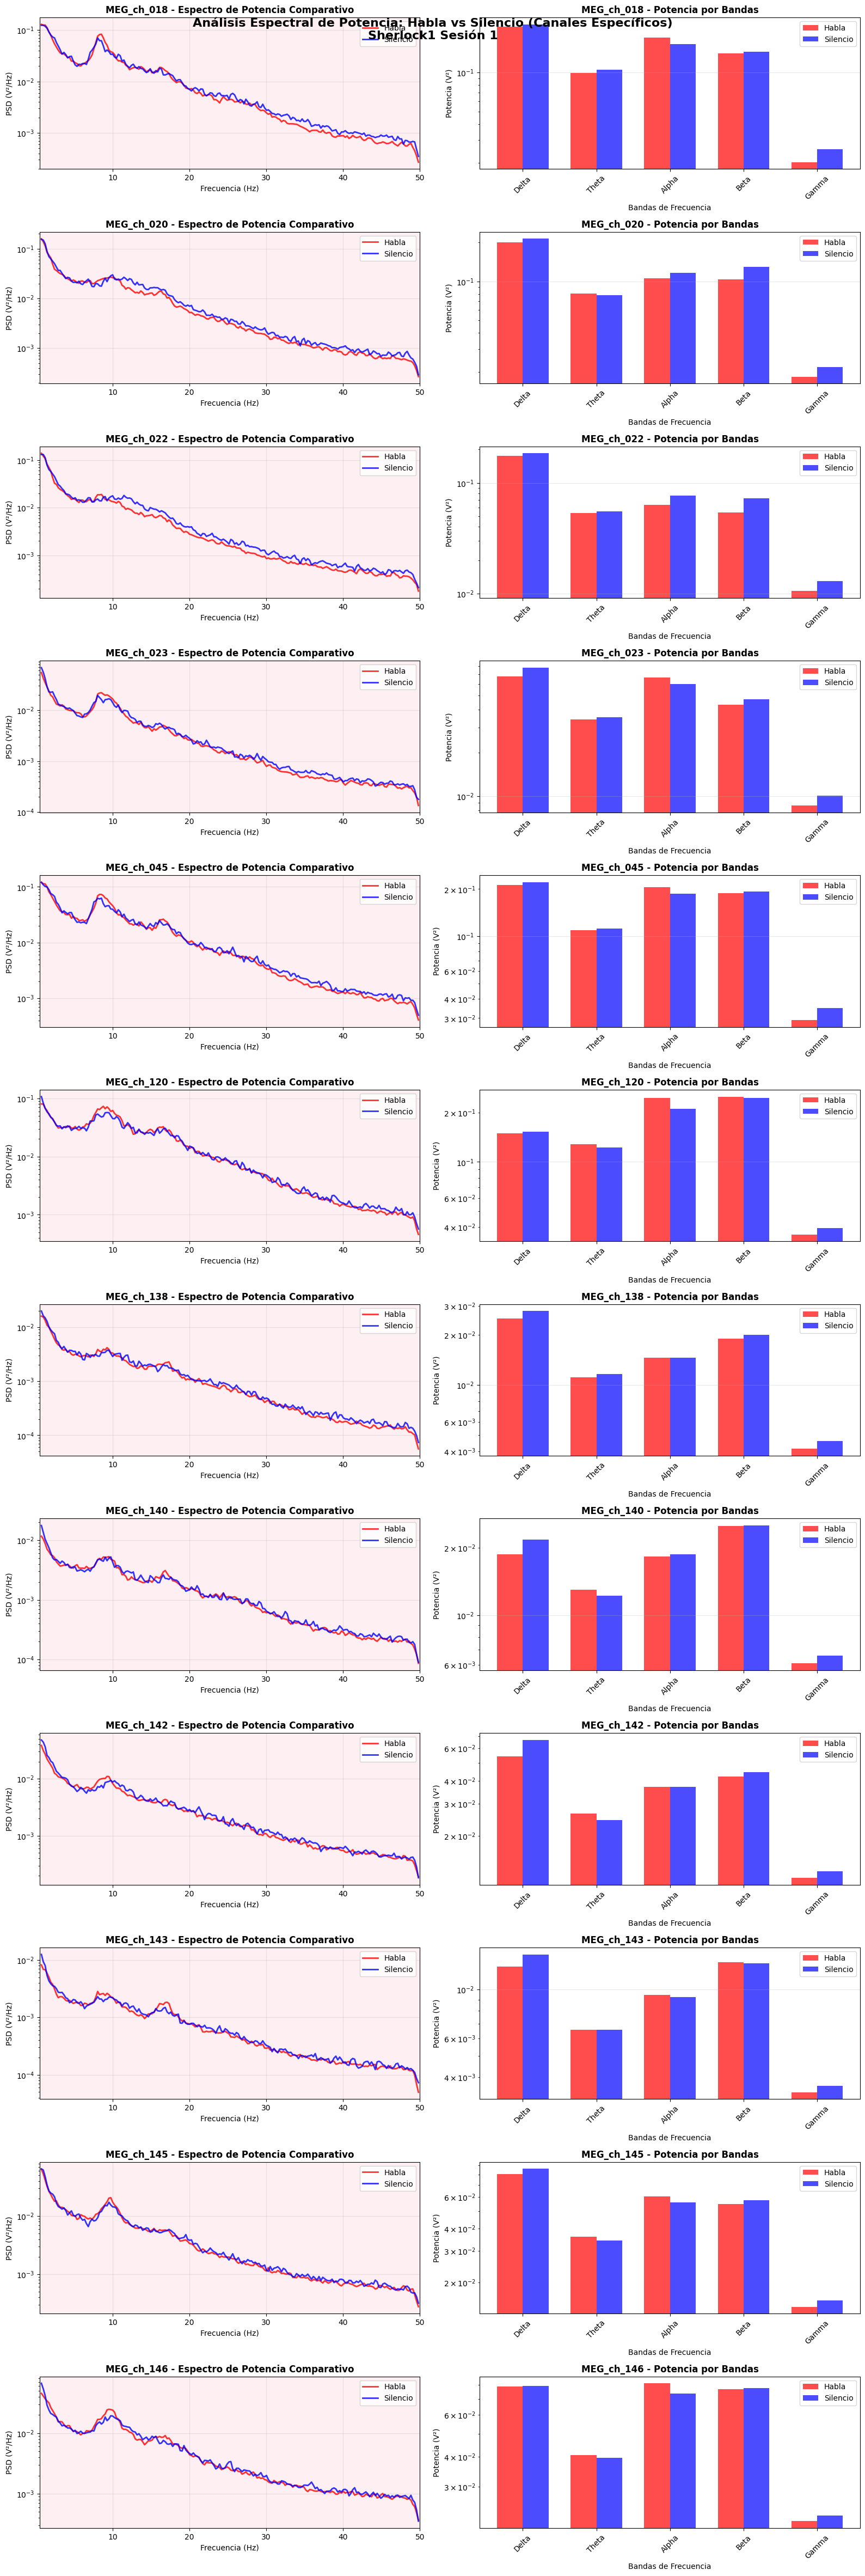


📊 RESUMEN ESTADÍSTICO POR BANDAS DE FRECUENCIA
   (Basado en 23 canales específicos para habla)

🎵 Banda Delta (0.5-4 Hz):
  📈 Habla    - Media: 1.15e-01 ± 6.86e-02
  📉 Silencio - Media: 1.21e-01 ± 6.97e-02
  📊 Ratio Habla/Silencio: 0.95
  ➡️ Actividad similar

🎵 Banda Theta (4-8 Hz):
  📈 Habla    - Media: 5.93e-02 ± 3.46e-02
  📉 Silencio - Media: 5.98e-02 ± 3.53e-02
  📊 Ratio Habla/Silencio: 0.99
  ➡️ Actividad similar

🎵 Banda Alpha (8-13 Hz):
  📈 Habla    - Media: 1.11e-01 ± 6.87e-02
  📉 Silencio - Media: 1.06e-01 ± 6.22e-02
  📊 Ratio Habla/Silencio: 1.05
  ➡️ Actividad similar

🎵 Banda Beta (13-30 Hz):
  📈 Habla    - Media: 1.01e-01 ± 6.58e-02
  📉 Silencio - Media: 1.07e-01 ± 6.74e-02
  📊 Ratio Habla/Silencio: 0.95
  ➡️ Actividad similar

🎵 Banda Gamma (30-50 Hz):
  📈 Habla    - Media: 1.84e-02 ± 9.61e-03
  📉 Silencio - Media: 2.08e-02 ± 1.08e-02
  📊 Ratio Habla/Silencio: 0.88
  ➡️ Actividad similar


In [91]:
# === ANÁLISIS ESPECTRAL: POTENCIA POR BANDAS DE FRECUENCIA ===

from scipy import signal
from scipy.fft import fft, fftfreq
import numpy as np

# Configuración para análisis espectral
SPECTRAL_CONFIG = {
    'freq_range': (0.5, 50),  # Rango de frecuencias en Hz
    'nperseg': 1024,          # Longitud de segmento para espectrograma
    'overlap_ratio': 0.5,     # Ratio de solapamiento
    'freq_bands': {           # Bandas de frecuencia de interés
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 13),
        'Beta': (13, 30),
        'Gamma': (30, 50)
    },
    'figsize': (20, 15)
}

# Canales específicos para análisis de habla (índices de sensores MEG)
SENSORS_SPEECH_MASK = [18, 20, 22, 23, 45, 120, 138, 140, 142, 143, 145, 146, 147, 149, 175, 176, 177, 179, 180, 198, 271, 272, 275]

def calculate_power_spectral_density(data, sfreq, freq_range=(0.5, 50), nperseg=1024):
    """
    Calcula la densidad espectral de potencia usando el método de Welch
    """
    freqs, psd = signal.welch(data, fs=sfreq, nperseg=nperseg, 
                             noverlap=int(nperseg * SPECTRAL_CONFIG['overlap_ratio']))
    
    # Filtrar solo el rango de frecuencias de interés
    freq_mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
    
    return freqs[freq_mask], psd[freq_mask]

def calculate_band_power(freqs, psd, band_range):
    """
    Calcula la potencia en una banda de frecuencia específica
    """
    band_mask = (freqs >= band_range[0]) & (freqs <= band_range[1])
    if np.sum(band_mask) == 0:
        return 0
    return np.trapz(psd[band_mask], freqs[band_mask])

def create_spectral_analysis(df):
    """
    Crea análisis espectral comparando períodos de silencio vs habla
    """
    if df is None or df.empty:
        print("❌ No hay datos para análisis espectral")
        return
    
    print("🔬 Iniciando análisis espectral de potencia...")
    
    # Preparar datos
    meg_cols = [col for col in df.columns if col.startswith('MEG_')]
    sfreq = processed_sfreq  # Usar la frecuencia de muestreo global
    
    # Seleccionar solo los canales específicos para análisis de habla
    # El formato correcto es MEG_ch_XXX, no MEG_XXXX
    selected_channels = []
    for sensor_idx in SENSORS_SPEECH_MASK:
        channel_name = f'MEG_ch_{sensor_idx:03d}'  # Formato MEG_ch_XXX
        if channel_name in meg_cols:
            selected_channels.append(channel_name)
    
    if not selected_channels:
        print("❌ No se encontraron canales válidos en SENSORS_SPEECH_MASK")
        print(f"🔍 Formato de canales buscado: MEG_ch_XXX")
        print(f"🔍 Primeros canales disponibles: {meg_cols[:5]}")
        return
    
    n_channels = len(selected_channels)
    print(f"📊 Analizando {n_channels} canales específicos para habla:")
    print(f"   Canales: {selected_channels[:5]}{'...' if len(selected_channels) > 5 else ''}")
    print(f"   Índices de sensores: {SENSORS_SPEECH_MASK[:5]}{'...' if len(SENSORS_SPEECH_MASK) > 5 else ''}")
    
    # Crear máscaras para habla y silencio
    habla_mask = (df['kind'] == 'word') | (df['kind'] == 'phoneme')
    silencio_mask = df['kind'] == 'silence'
    
    print(f"🔍 Muestras de habla: {habla_mask.sum():,}")
    print(f"🔍 Muestras de silencio: {silencio_mask.sum():,}")
    
    if habla_mask.sum() == 0 or silencio_mask.sum() == 0:
        print("❌ No hay suficientes datos de habla o silencio para el análisis")
        return
    
    # Configurar la figura - 2 columnas: espectros combinados + barras
    # Usar un número razonable de filas para evitar figuras demasiado grandes
    max_rows = min(n_channels, 12)  # Máximo 12 filas para mantener legibilidad
    fig, axes = plt.subplots(max_rows, 2, figsize=(16, max_rows * 4))
    if max_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Diccionarios para almacenar resultados
    band_powers_habla = {band: [] for band in SPECTRAL_CONFIG['freq_bands']}
    band_powers_silencio = {band: [] for band in SPECTRAL_CONFIG['freq_bands']}
    
    channels_to_plot = selected_channels[:max_rows]  # Solo mostrar los primeros canales
    
    for i, channel in enumerate(channels_to_plot):
        print(f"  📈 Procesando {channel}...")
        
        # Extraer datos de habla y silencio
        data_habla = df.loc[habla_mask, channel].values
        data_silencio = df.loc[silencio_mask, channel].values
        
        # Calcular PSD para habla
        freqs_habla, psd_habla = calculate_power_spectral_density(
            data_habla, sfreq, SPECTRAL_CONFIG['freq_range'], SPECTRAL_CONFIG['nperseg']
        )
        
        # Calcular PSD para silencio
        freqs_silencio, psd_silencio = calculate_power_spectral_density(
            data_silencio, sfreq, SPECTRAL_CONFIG['freq_range'], SPECTRAL_CONFIG['nperseg']
        )
        
        # === COLUMNA 1: ESPECTROS COMBINADOS (HABLA + SILENCIO) ===
        axes[i, 0].semilogy(freqs_habla, psd_habla, 'r-', linewidth=2, alpha=0.8, label='Habla')
        axes[i, 0].semilogy(freqs_silencio, psd_silencio, 'b-', linewidth=2, alpha=0.8, label='Silencio')
        axes[i, 0].set_title(f'{channel} - Espectro de Potencia Comparativo', fontsize=12, fontweight='bold')
        axes[i, 0].set_xlabel('Frecuencia (Hz)')
        axes[i, 0].set_ylabel('PSD (V²/Hz)')
        axes[i, 0].grid(True, alpha=0.3)
        axes[i, 0].set_xlim(SPECTRAL_CONFIG['freq_range'])
        axes[i, 0].legend()
        
        # Añadir bandas de frecuencia como fondo
        for band_name, (f_low, f_high) in SPECTRAL_CONFIG['freq_bands'].items():
            axes[i, 0].axvspan(f_low, f_high, alpha=0.1, label=band_name if i == 0 else "")
        
        # === COLUMNA 2: COMPARACIÓN POR BANDAS ===
        band_names = list(SPECTRAL_CONFIG['freq_bands'].keys())
        habla_powers = []
        silencio_powers = []
        
        for band_name, band_range in SPECTRAL_CONFIG['freq_bands'].items():
            power_habla = calculate_band_power(freqs_habla, psd_habla, band_range)
            power_silencio = calculate_band_power(freqs_silencio, psd_silencio, band_range)
            
            habla_powers.append(power_habla)
            silencio_powers.append(power_silencio)
            
            # Almacenar para análisis posterior
            band_powers_habla[band_name].append(power_habla)
            band_powers_silencio[band_name].append(power_silencio)
        
        x_pos = np.arange(len(band_names))
        width = 0.35
        
        bars1 = axes[i, 1].bar(x_pos - width/2, habla_powers, width, 
                              label='Habla', color='red', alpha=0.7)
        bars2 = axes[i, 1].bar(x_pos + width/2, silencio_powers, width,
                              label='Silencio', color='blue', alpha=0.7)
        
        axes[i, 1].set_title(f'{channel} - Potencia por Bandas', fontsize=12, fontweight='bold')
        axes[i, 1].set_xlabel('Bandas de Frecuencia')
        axes[i, 1].set_ylabel('Potencia (V²)')
        axes[i, 1].set_xticks(x_pos)
        axes[i, 1].set_xticklabels(band_names, rotation=45)
        axes[i, 1].grid(True, alpha=0.3, axis='y')
        axes[i, 1].set_yscale('log')
        axes[i, 1].legend()
    
    # Procesar todos los canales seleccionados para el análisis estadístico (no solo los mostrados)
    for channel in selected_channels[max_rows:]:  # Procesar canales restantes sin mostrar
        print(f"  📊 Analizando (sin mostrar) {channel}...")
        
        data_habla = df.loc[habla_mask, channel].values
        data_silencio = df.loc[silencio_mask, channel].values
        
        freqs_habla, psd_habla = calculate_power_spectral_density(
            data_habla, sfreq, SPECTRAL_CONFIG['freq_range'], SPECTRAL_CONFIG['nperseg']
        )
        freqs_silencio, psd_silencio = calculate_power_spectral_density(
            data_silencio, sfreq, SPECTRAL_CONFIG['freq_range'], SPECTRAL_CONFIG['nperseg']
        )
        
        for band_name, band_range in SPECTRAL_CONFIG['freq_bands'].items():
            power_habla = calculate_band_power(freqs_habla, psd_habla, band_range)
            power_silencio = calculate_band_power(freqs_silencio, psd_silencio, band_range)
            
            band_powers_habla[band_name].append(power_habla)
            band_powers_silencio[band_name].append(power_silencio)
    
    plt.suptitle(f'Análisis Espectral de Potencia: Habla vs Silencio (Canales Específicos)\n{SELECTED_TASK} Sesión {SELECTED_SESSION}', 
                fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    # === RESUMEN ESTADÍSTICO ===
    print("\n" + "="*60)
    print("📊 RESUMEN ESTADÍSTICO POR BANDAS DE FRECUENCIA")
    print(f"   (Basado en {len(selected_channels)} canales específicos para habla)")
    print("="*60)
    
    for band_name in SPECTRAL_CONFIG['freq_bands'].keys():
        powers_h = np.array(band_powers_habla[band_name])
        powers_s = np.array(band_powers_silencio[band_name])
        
        ratio = np.mean(powers_h) / np.mean(powers_s) if np.mean(powers_s) > 0 else np.inf
        
        print(f"\n🎵 Banda {band_name} ({SPECTRAL_CONFIG['freq_bands'][band_name][0]}-{SPECTRAL_CONFIG['freq_bands'][band_name][1]} Hz):")
        print(f"  📈 Habla    - Media: {np.mean(powers_h):.2e} ± {np.std(powers_h):.2e}")
        print(f"  📉 Silencio - Media: {np.mean(powers_s):.2e} ± {np.std(powers_s):.2e}")
        print(f"  📊 Ratio Habla/Silencio: {ratio:.2f}")
        
        if ratio > 1.5:
            print(f"  ⬆️ MAYOR actividad en habla")
        elif ratio < 0.67:
            print(f"  ⬇️ MAYOR actividad en silencio")
        else:
            print(f"  ➡️ Actividad similar")

# === EJECUTAR ANÁLISIS ESPECTRAL ===
if unified_df is not None and processed_sfreq is not None:
    create_spectral_analysis(unified_df)
else:
    print("❌ No se puede realizar análisis espectral - faltan datos o frecuencia de muestreo")